<a href="https://colab.research.google.com/github/alexiadorneles/pucrs-machine-learning-t2/blob/main/machine_learning_t2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T2 Aprendizado de Máquina

Classificador de Leões vs Tigres

Integrantes: Aléxia Dorneles, <coloquem os nomes de vocês aqui>

In [2]:
# baixando o dataset
!pip install gdown
!gdown --id 124-_PFnJTMPQyb_KtKVZnrnK_P06X7CO
!unzip /content/dataset.zip -d /content/full_dataset

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=124-_PFnJTMPQyb_KtKVZnrnK_P06X7CO
From (redirected): https://drive.google.com/uc?id=124-_PFnJTMPQyb_KtKVZnrnK_P06X7CO&confirm=t&uuid=d6a51cc1-8d16-4a2b-855f-2711f40faf99
To: /content/dataset.zip
100% 30.5M/30.5M [00:00<00:00, 45.7MB/s]
Archive:  /content/dataset.zip
   creating: /content/full_dataset/dataset/
   creating: /content/full_dataset/dataset/tiger/
  inflating: /content/full_dataset/__MACOSX/dataset/._tiger  
   creating: /content/full_dataset/dataset/lion/
  inflating: /content/full_dataset/__MACOSX/dataset/._lion  
  inflating: /content/full_dataset/dataset/tiger/flickr_wild_001063.jpg  
  inflating: /content/full_dataset/dataset/tiger/flickr_wild_001077.jpg  
  inflating: /content/full_dataset/

In [13]:
# ! rm -r /content/dataset
# ! rm -r /content/full_dataset
# ! rm /content/dataset.zip

In [3]:
# separando o dataset entre treino e teste
import os
import shutil
import random

def split_dataset(dataset_dir, output_dir, train_ratio=0.7):
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        # Ignorar pastas indesejadas como __MACOSX
        if not os.path.isdir(class_path) or class_name == '__MACOSX':
            continue

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        random.shuffle(images)
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        for img in train_images:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        for img in test_images:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(test_dir, class_name, img)
            )

        print(f"Classe '{class_name}': {len(train_images)} imagens para treino, {len(test_images)} para teste.")

# Execute a função com o caminho atualizado
split_dataset('/content/full_dataset/dataset', '/content/dataset')


Classe 'tiger': 199 imagens para treino, 86 para teste.
Classe 'lion': 233 imagens para treino, 100 para teste.


In [4]:
# configuração incial, conforme exemplo de aula: https://colab.research.google.com/drive/1bUkHwfEq_o3Hhx2p3yt37DutTXYSIEmF?usp=sharing#scrollTo=HkrVIvo4mCmp

# Importação de bibliotecas:
# - torchvision, torch e numpy: Para manipulação de dados, criação e treinamento de redes neurais.
# - matplotlib e seaborn: Para visualização de dados.
# - tqdm: Para exibir barras de progresso.
# - os: Para manipular o sistema de arquivos e variáveis de ambiente.

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import numpy as np
import torchvision
import random
import torch

import os

# Função set_seed(seed):
# Configura uma semente global para garantir reprodutibilidade nos experimentos:
# - Define seeds para random, numpy e PyTorch (CPU e GPU).
# - Força comportamento determinístico do backend cuDNN para operações em GPU.

def set_seed(seed=1234):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()


# Configuração do dispositivo:
# - Verifica se há GPU disponível para usar CUDA; caso contrário, utiliza CPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# redimensionar as imagens para 256x256
img_size = (256,256)
transformations = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])

# carregar dados de treino e teste como data loaders do pytorch
train = datasets.ImageFolder('./dataset/train',transform=transformations)
test = datasets.ImageFolder('./dataset/test', transform=transformations)
trainloader = DataLoader(train, batch_size=64, shuffle=True)
testloader = DataLoader(test, batch_size=64, shuffle=False)

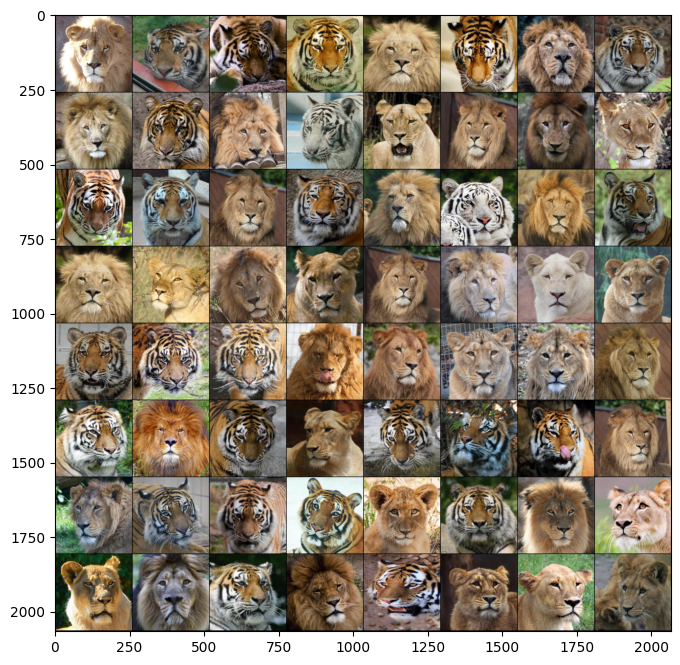

In [6]:
# mostrando imagens do dataset

def imshow(img):
    plt.figure(figsize=(20,8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images = next(dataiter)
imshow(torchvision.utils.make_grid(images[0]))

## Usando Transfer Learning (ResNet)

In [7]:
# Carrega o modelo ResNet-50 pré-treinado
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

# Substitui a última camada para uma nova tarefa com 2 classes
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [8]:
# Congelamos todas as camadas, exceto a última (fc) para reaproveitar o treinamento da resnet
for name, params in resnet.named_parameters():
    if name not in ('fc.weight', 'fc.bias'):
        params.requires_grad = False  # Congela os pesos (não atualiza durante o treinamento)

In [9]:
# Funções de treinamento

def validation(model, loader, criterion):
    model.eval()  # Coloca o modelo em modo de avaliação
    val_loss = 0.0
    with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória e acelerar
        for images, labels in loader:  # Itera pelo conjunto de validação
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Faz a previsão com o modelo
            loss = criterion(outputs, labels)  # Calcula a perda em relação aos rótulos verdadeiros
            val_loss += loss.item()  # Soma a perda para obter o valor total

    return val_loss / len(loader)  # Retorna a perda média de validação

def train(model, trainloader, testloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()  # Coloca o modelo em modo de treinamento
        running_loss = 0.0
        for images, labels in tqdm(trainloader):  # Itera pelo conjunto de treinamento com barra de progresso
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Zera os gradientes acumulados

            outputs = model(images)  # Faz a previsão com o modelo
            loss = criterion(outputs, labels)  # Calcula a perda em relação aos rótulos verdadeiros
            loss.backward()  # Calcula os gradientes (backpropagation)
            optimizer.step()  # Atualiza os pesos do modelo

            running_loss += loss.item()  # Acumula a perda

        val_loss = validation(model, testloader, criterion)  # Calcula a perda de validação
        print(f'Epoch: {epoch + 1} | Training Loss: {running_loss / len(trainloader):.4f} | Validation Loss: {val_loss:.4f}')


In [10]:
# Configuração de treinamento

resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
epochs = 3

In [11]:
# Treinando com transfer learning

train(resnet, trainloader, testloader, optimizer, criterion, epochs)

100%|██████████| 7/7 [03:00<00:00, 25.76s/it]


Epoch: 1 | Training Loss: 0.5751 | Validation Loss: 0.5082


100%|██████████| 7/7 [03:05<00:00, 26.54s/it]


Epoch: 2 | Training Loss: 0.3891 | Validation Loss: 0.3630


100%|██████████| 7/7 [03:00<00:00, 25.85s/it]


Epoch: 3 | Training Loss: 0.2603 | Validation Loss: 0.2583


A rede atinge: 98.9247311827957% de acurácia


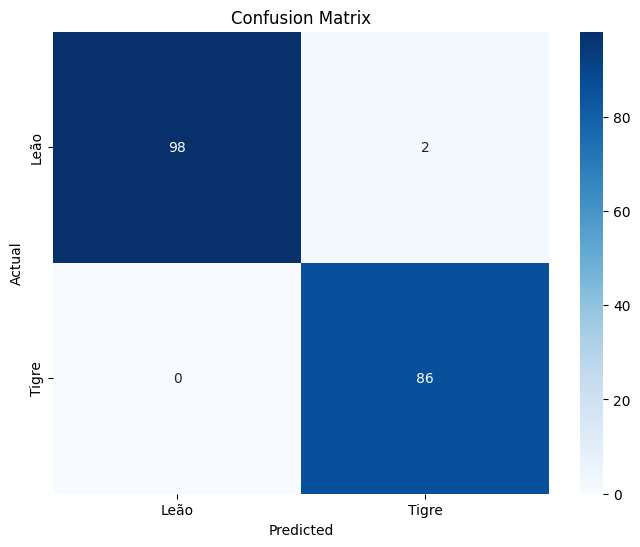

In [13]:
# Avaliando o modelo

def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return (corrected / total) * 100

def confusion_matrix(model, loader):
    model.eval()
    num_classes = 2
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for true, pred in zip(labels, predicted):
                confusion_matrix[true.item(), pred.item()] += 1

    confusion_matrix = confusion_matrix.cpu().numpy()
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g',
                     xticklabels=['Leão', 'Tigre'], yticklabels=['Leão', 'Tigre'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()
    return ax

print(f'A rede atinge: {accuracy(resnet, testloader)}% de acurácia')
conf_mat = confusion_matrix(resnet, testloader)

## Testando uma imagem:

In [22]:
# baixando as imagens de teste
!gdown --id 1yhAgTh2Qwkdu0Kju78rEEEXNVNI_wCri -O aslan.jpg
!gdown --id 1LIWLWAcWyrjbK1I6hD4KhWf6-nrZzmJz -O richard-parker.jpg

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yhAgTh2Qwkdu0Kju78rEEEXNVNI_wCri
To: /content/aslan.jpg
100% 45.0k/45.0k [00:00<00:00, 48.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LIWLWAcWyrjbK1I6hD4KhWf6-nrZzmJz
To: /content/richard-parker.jpg
100% 90.1k/90.1k [00:00<00:00, 92.1MB/s]


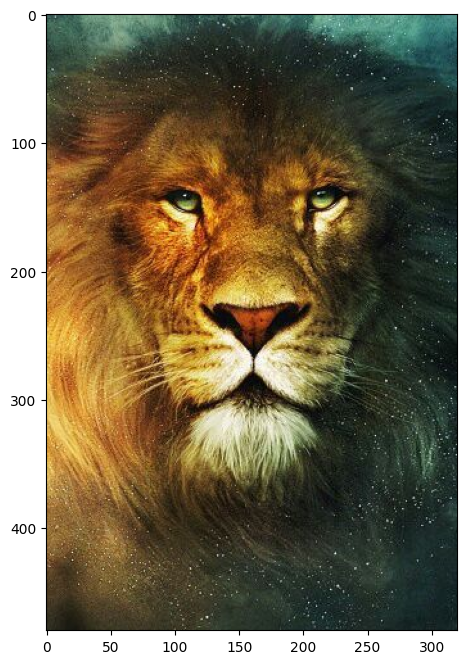

Aslan (Narnia): Leão


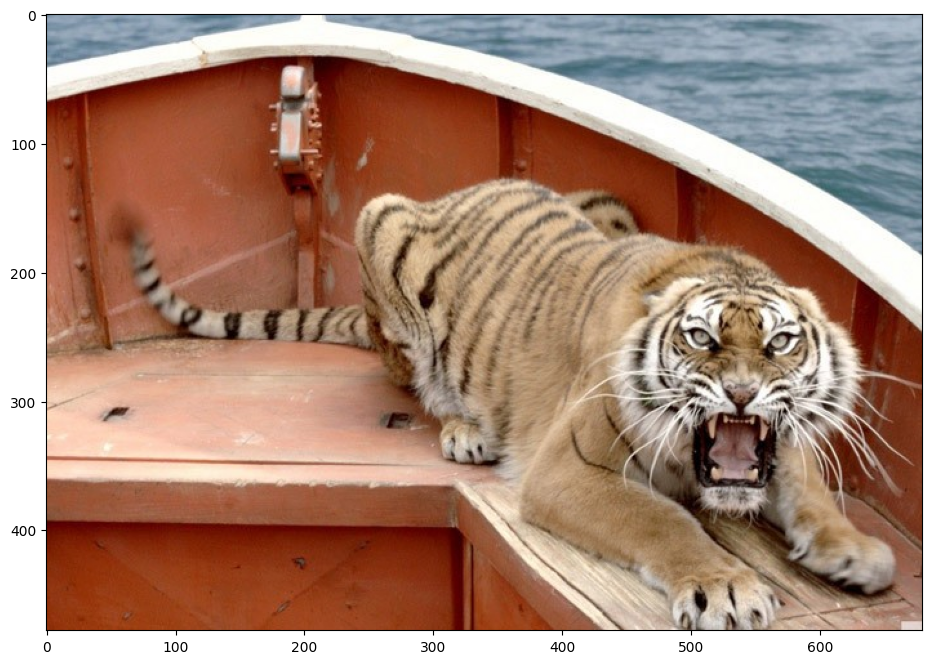

Richard Parker (Life of Pi): Tigre


In [23]:
from PIL import Image
import torchvision.transforms.functional as TF

def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Leão' if result == 0 else 'Tigre'

x = Image.open('aslan.jpg').convert('RGB')
x = transformations(x)
imshow(transforms.ToTensor()(Image.open('aslan.jpg')))

print(f'Aslan (Narnia): {predict(resnet, x)}')

x = Image.open('richard-parker.jpg').convert('RGB')
x = transformations(x)
imshow(transforms.ToTensor()(Image.open('richard-parker.jpg')))
print(f'Richard Parker (Life of Pi): {predict(resnet, x)}')